In [17]:
# Importing needed libraries:
import pandas as pd
import numpy as np
import matplotlib as plt
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# Importing the dataset to perform EDA:

cve_data = pd.read_csv("cve.csv")
cve_data.replace('?', pd.NA, inplace=True)
cve_data.dropna(inplace=True)
cve_data.fillna('Unknown', inplace=True)
cve_data.head()

,CVE,mod_date,pub_date,cvss,cwe_code,cwe_name,summary,access_authentication,access_complexity,access_vector,impact_availability,impact_confidentiality,impact_integrity
138,CVE-2019-2211,2019-11-14 21:36:00,2019-11-13 18:15:00,7.8,89,Improper Neutralization of Special Elements u...,In createProjectionMapForQuery of TvProvider.j...,NONE,LOW,NETWORK,NONE,COMPLETE,NONE
139,CVE-2019-2212,2019-11-14 21:30:00,2019-11-13 18:15:00,4.9,200,Information Exposure,"In poisson_distribution of random, there is an...",NONE,LOW,LOCAL,NONE,COMPLETE,NONE
140,CVE-2019-2213,2019-11-14 21:24:00,2019-11-13 18:15:00,6.9,416,Use After Free,"In binder_free_transaction of binder.c, there ...",NONE,MEDIUM,LOCAL,COMPLETE,COMPLETE,COMPLETE
149,CVE-2019-2214,2019-11-14 21:19:00,2019-11-13 18:15:00,7.2,269,Improper Privilege Management,"In binder_transaction of binder.c, there is a ...",NONE,LOW,LOCAL,COMPLETE,COMPLETE,COMPLETE
150,CVE-2019-18793,2019-11-14 21:14:00,2019-11-13 20:15:00,4.3,79,Improper Neutralization of Input During Web P...,Parallels Plesk Panel 9.5 allows XSS in target...,NONE,MEDIUM,NETWORK,NONE,NONE,PARTIAL


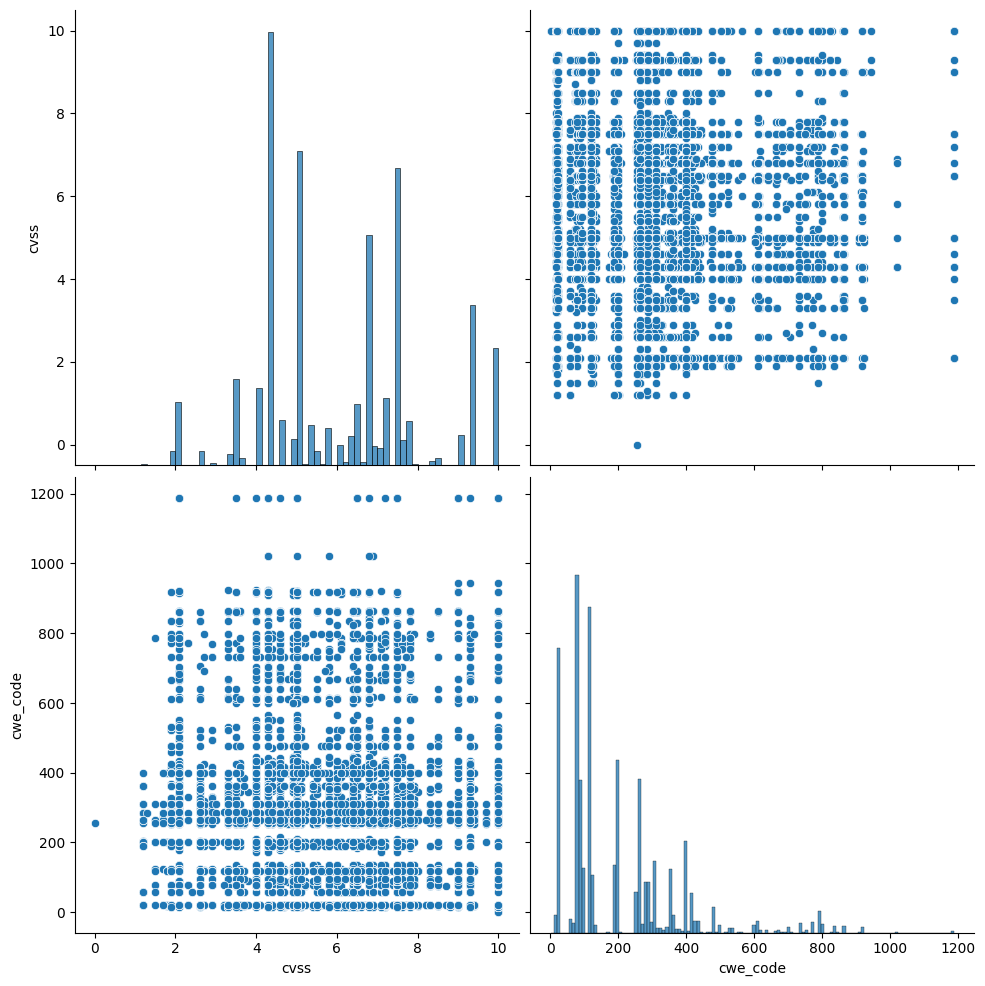

In [19]:
# Now, I will go ahead and visualize some of the data from the dataset to understand it's structure, meaning, etc.:

sns.pairplot(cve_data, height=5)

Text(0.5, 1.0, 'CVS Scores Across The Dataset')

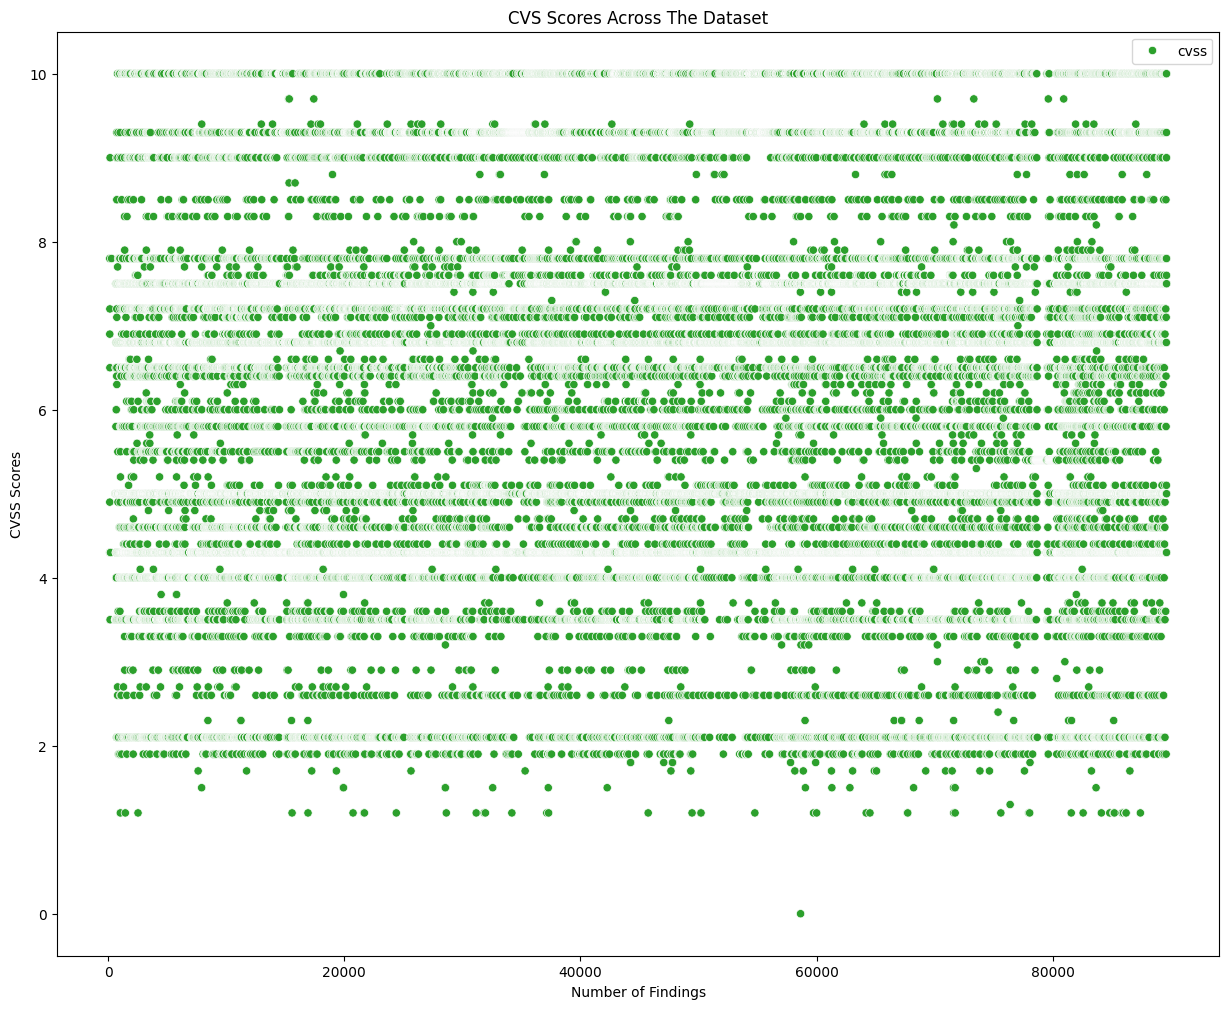

In [20]:

hues = {'cvss': 'tab:green',
        'cwe_code': 'tab:orange'
}

plt.figure(figsize=[15,12])
sns.scatterplot(cve_data[['cvss']], palette=hues, legend='auto')
plt.xlabel("Number of Findings")
plt.ylabel("CVSS Scores")
plt.title("CVS Scores Across The Dataset")

In [21]:
# Now, after taking a look at the quantities of CVSS scores, CWE codes and the other categorical metrics in the dataset, I decided to try out logistic regression to take advantage of the categorical data overwhelmingly present in the dataset.

X_features = cve_data[['cwe_code', 'access_authentication', 'access_complexity', 'access_vector', 'impact_availability', 'impact_confidentiality', 'impact_integrity']]
X_enc = pd.get_dummies(X_features)

scaler = StandardScaler()
X = scaler.fit_transform(X_enc)

# In order to leverage a Logistic Regression model, I need to create a new column in the dataset to apply categorical values to ranges of cvss scores to reduce complexity. I did this with creating a simple function and then applied it to the existing 'cvss' column
# and stored it in a new column. Finally, this column was then label-encoded.

def cvss_scores(score):
    if score <= 3.9:
        return 'Low'
    if score <= 6.9:
        return 'Medium'
    else:
        return 'High'
    
cve_data['cvss_category'] = cve_data['cvss'].apply(cvss_scores)

label_enc = LabelEncoder()
Y = label_enc.fit_transform(cve_data['cvss_category'])
print("The shape of both X and Y are currently: ", X.shape, Y.shape)

The shape of both X and Y are currently:  (88776, 19) (88776,)


In [22]:
# Now that I've selected my features, target variable and have encoded both and standardized the feature set, I am now ready to proceed with the train/test split to prepare the data for the Logistic Regression classifier.:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.2)

print("The shape of both X and Y training sets are: ", X_train.shape, Y_train.shape)
print(" The shape of both X and Y testing sets are: ",  X_test.shape, Y_test.shape)

The shape of both X and Y training sets are:  (71020, 19) (71020,)
 The shape of both X and Y testing sets are:  (17756, 19) (17756,)


In [23]:
# I am now ready to create and configure my Logistic Regression model. In order to plot this, I will leverage PCA to perform dimensionality reduction as the X setshave more than 2 features.:

Log_Mod = LogisticRegression(solver='lbfgs')
Log_Mod.fit(X_train, Y_train)
prediction = Log_Mod.predict(X_test)

coef_result = Log_Mod.coef_
inter_result = Log_Mod.intercept_

print("The coefficient and intercept results are: ", coef_result, inter_result)


The coefficient and intercept results are:  [[-9.74243955e-03 -3.70148791e-01  2.59501363e+00 -2.57967739e+00
  -4.41779546e+00  3.12699669e+00 -1.68006008e+00 -6.61792810e-01
  -9.34582561e+00  8.78634595e+00  9.70109841e+00 -6.53089701e+00
  -1.88972964e+00  9.11325229e+00 -5.95793063e+00 -1.63635403e+00
   7.48659437e+00 -5.12343786e+00 -1.23513651e+00]
 [-6.99263558e-02  2.91410122e-01 -2.11512258e+00  2.10310710e+00
   3.27953211e+00 -2.62008852e+00  1.54693510e+00  6.71078204e-01
   6.93604837e+00 -6.60786003e+00 -1.05763766e+01  7.24650814e+00
   1.93625133e+00 -9.92692019e+00  6.66763309e+00  1.61502178e+00
  -7.90856296e+00  5.60264645e+00  1.13213608e+00]
 [ 7.96687953e-02  7.87386685e-02 -4.79891057e-01  4.76570291e-01
   1.13826335e+00 -5.06908173e-01  1.33124985e-01 -9.28539421e-03
   2.40977725e+00 -2.17848592e+00  8.75278207e-01 -7.15611132e-01
  -4.65216902e-02  8.13667901e-01 -7.09702466e-01  2.13322438e-02
   4.21968595e-01 -4.79208592e-01  1.03000439e-01]] [  7.83676

In [24]:
# Next, I will continue with evaluating the model's accuracy.:

accuracy = metrics.accuracy_score(Y_test, prediction)
classification_report = metrics.classification_report(Y_test, prediction)

print("The accuracy of the Logistic Regression model is: ", accuracy, "\nAnd the classification report is below as well: ", "\n", classification_report)

The accuracy of the Logistic Regression model is:  0.9996057670646542 
And the classification report is below as well:  
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5916
           1       1.00      1.00      1.00      1496
           2       1.00      1.00      1.00     10344

    accuracy                           1.00     17756
   macro avg       1.00      1.00      1.00     17756
weighted avg       1.00      1.00      1.00     17756



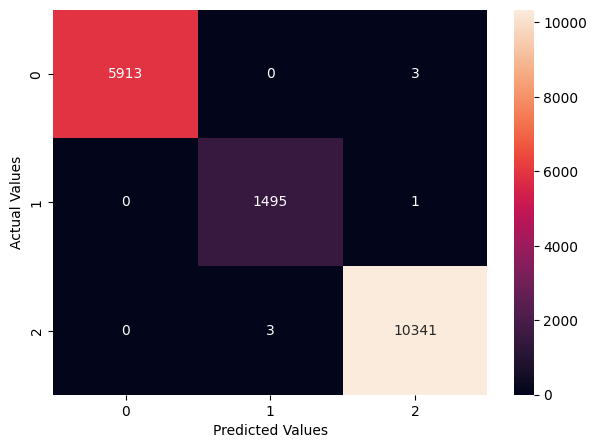

In [25]:
# I will now plot a confusion matrix to make it easier to determine the quantity of true positives/negatives and false positives/negatives.:

Y_test_unencoded = label_enc.inverse_transform(Y_test)
prediction_unencoded = label_enc.inverse_transform(prediction)

conf_mat = metrics.confusion_matrix(Y_test_unencoded, prediction_unencoded)
plt.figure(figsize=[7,5])
sns.heatmap(conf_mat, annot=True, fmt="d") # fmt allows for encoded strings (scientific notation in this case) to be shown as integers instead. "d" stands for decimal integers.
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

The coefficient and intercept results are:  [[ 0.47881683  0.36218722]
 [-0.16621278 -0.24407775]
 [-0.31260404 -0.11810946]] [ 0.08646975 -0.9606518   0.87418205]
0.9996057670646542


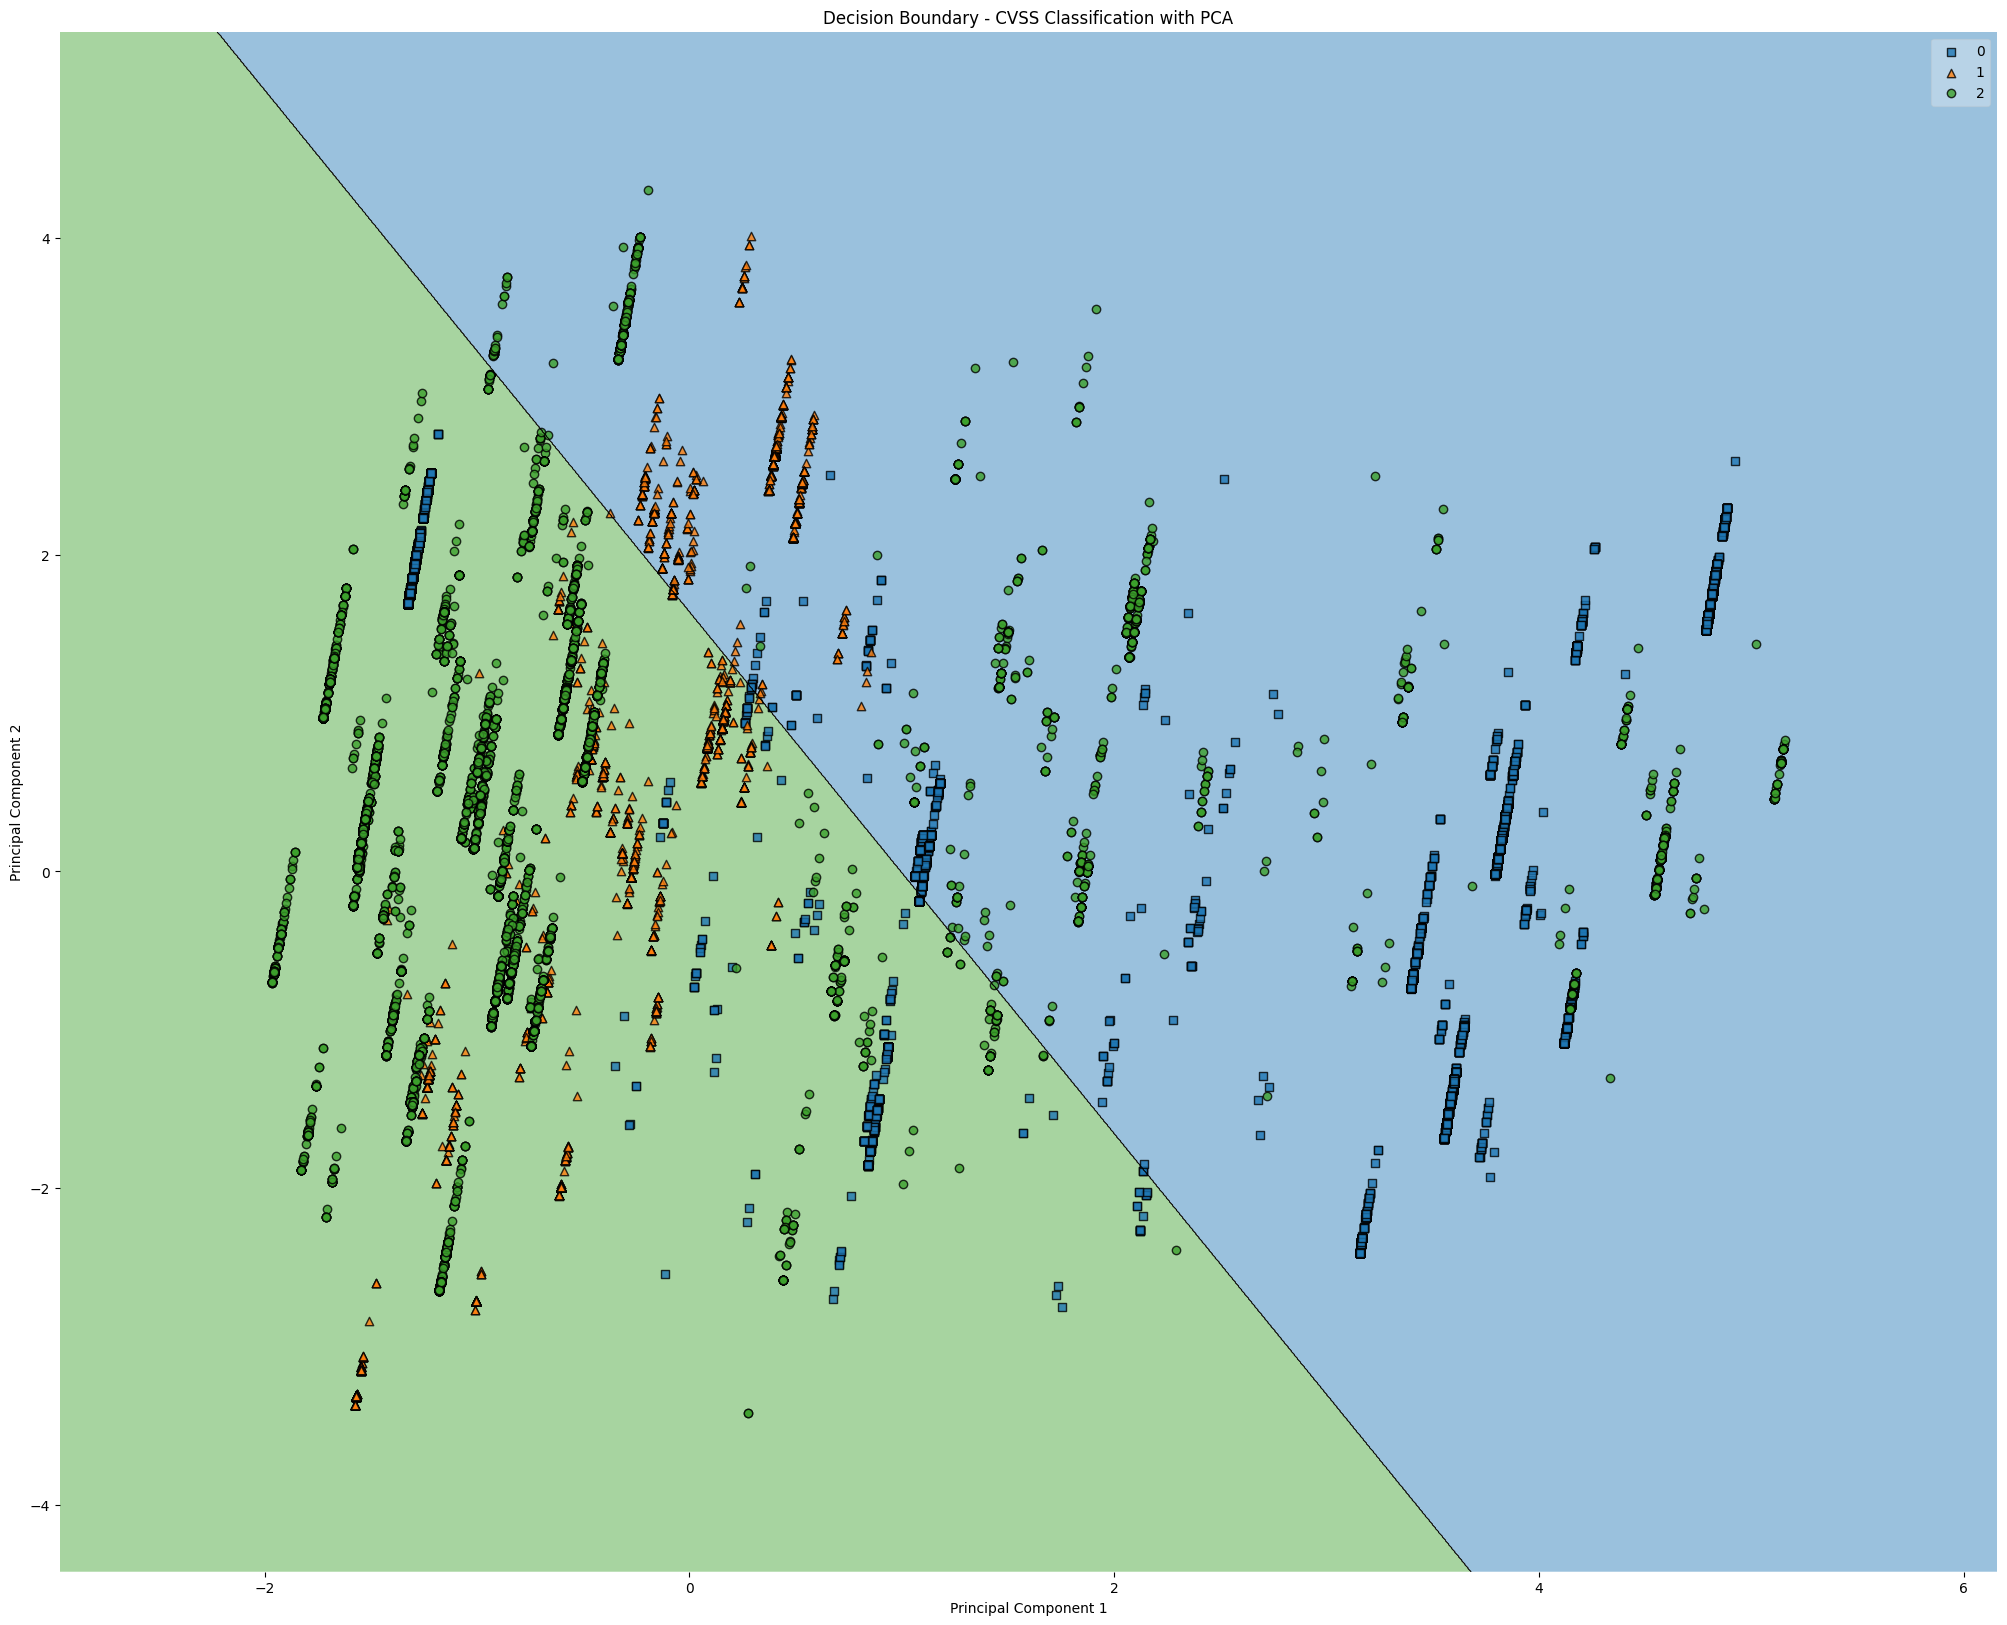

In [26]:
# last but not least, let's make sure we can actually visualize the model. For this, I will be using mlxtend, a neat library that makes it easy to visualize ML models.

pca_enc = PCA(n_components=2)
X_train_pca = pca_enc.fit_transform(X_train)
X_test_pca = pca_enc.fit(X_test)

Log_Mod = LogisticRegression(solver='lbfgs')
Log_Mod.fit(X_train_pca, Y_train)

coef_result = Log_Mod.coef_
inter_result = Log_Mod.intercept_

print("The coefficient and intercept results are: ", coef_result, inter_result)
print(accuracy)

plt.figure(figsize=[25,20])
plot_decision_regions(X_train_pca, Y_train, clf=Log_Mod)
plt.title("Decision Boundary - CVSS Classification with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Conclusion: This shows that I have achieved a high degree of accuracy based on the selected data. I am successfully able to retain a high degree of accuracy as a result of classifying the CVSS categories. Additionally, the decision boundary should be marked with
# as minimal overalp as possible. However, we can see some overlap here with the decision boundary which still leaves room for improvement. With that being said, this is a great start.

In [27]:
# Now that we have an idea of the low, med and high severity CVSS scores across the board, I am curious now about the confidentiality, integrity and availability impacts on each CVE detailed in the dataset. For this, I will implement a multinomial classification method
# called One-vs-Rest (OvR). I will perform this for each class and plot them out to get a better picture for predicting multiple impacts.

# First, I will start from scratch and encode the target class and features as well.:

X_features = pd.get_dummies(cve_data[['impact_confidentiality', 'impact_integrity']])
Y = cve_data['impact_availability']
Y_enc = label_enc.fit_transform(Y)





In [28]:
# Next, I will begin to create the train/test split as previously done for the logistic regression model.:

X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_enc, random_state=42, test_size=0.33)

print("The shape of the training sets are: ", X_train.shape, Y_train.shape)
print("The shape of the testing sets are: ", X_test.shape, Y_test.shape)

The shape of the training sets are:  (59479, 6) (59479,)
The shape of the testing sets are:  (29297, 6) (29297,)


In [29]:
# Now I can begin creating, fitting and evaluating the model's accuracy. In this case, I've chosen to go with a Support Vector Machine (SVM).

svm = SVC(kernel='linear', random_state=42)
OvO = OneVsOneClassifier(svm)
OvO.fit(X_train, Y_train) 

prediction = OvO.predict(X_test)

metric_report = metrics.classification_report(Y_test, prediction)
print("Here is the classification report for the model.: ", metric_report)

Here is the classification report for the model.:                precision    recall  f1-score   support

           0       0.99      0.82      0.90      6758
           1       0.70      0.94      0.80     10654
           2       0.92      0.73      0.82     11885

    accuracy                           0.83     29297
   macro avg       0.87      0.83      0.84     29297
weighted avg       0.86      0.83      0.83     29297



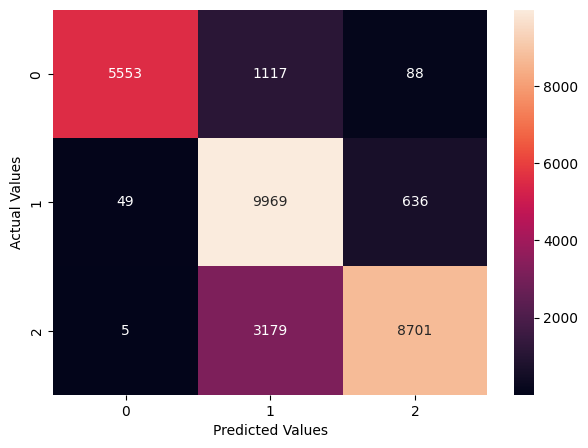

In [30]:
conf_mat2 = metrics.confusion_matrix(Y_test, prediction)

plt.figure(figsize=[7,5])
sns.heatmap(conf_mat2, annot=True, fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()